# ASSIGNMENT #5 - UPPER AIR DATA #
Due: 08 April 2024 @ 11:59p

Purpose:\
The purpose of this assignment is to first collect data from an online archive using a user-created function.  The data is then plotted on a map to continue to familiarize with plotting weather data on maps.  

Overview:\
In this assignment you will read in rawinsonde observations in a function and plot that data.


| | UPDATE TO YOUR INFORMATION | 
| :- | :- |
| Created By | Jared W. Marquis |
| Creation Date | 21 January 2024 |
| Course | ATSC 270 - Computer Concepts in Meteorology |

In [ ]:
### UPDATE TO YOUR INFORMATION ###
#information allowing anyone with the code to print the author and contact information
__author__    = "Rebecca Jacoby"
__contact__   = "rebecca.jacoby@ndus.edu"

### IMPORT REQUIRED LIBRARIES ###

In [1]:
import numpy as np
from datetime import datetime

from assignment_5_functions import get_raobs, select_press

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


### DOWNLOAD OBSERVATIONS FROM  FILE ###
RAwinsonde OBservations (RAOBs) are available from the Iowa State Environmental Mesonet (IEM) archive.  This data can be accessed using the siphon module.  All this will be done within the assignment_5_functions file.  Note, RAOBs don't specify latitude/longitude so we need to add it using a metpy function -> *add_station_lat_lon(data)*.

In [2]:
#grab data from 00Z on 26 December 2023

dt = datetime(2023,12,26,0)

data = get_raobs(dt)
print(data)

       pressure   height  temperature  dewpoint  direction  speed station  \
0         979.0    386.0         -4.7      -5.4       15.0    2.0    CWPL   
1         968.0    476.0         -4.3      -7.2        NaN    NaN    CWPL   
2         952.0    606.0         -5.5      -7.6        NaN    NaN    CWPL   
3         951.6    609.0          NaN       NaN      355.0    5.0    CWPL   
4         947.0    647.0         -5.5      -8.8        NaN    NaN    CWPL   
...         ...      ...          ...       ...        ...    ...     ...   
14695       5.9  34574.0        -45.3     -84.3        NaN    NaN    KYXY   
14696       5.7  34747.0          NaN       NaN      145.0   15.0    KYXY   
14697       5.4  35159.0        -48.7     -86.7        NaN    NaN    KYXY   
14698       4.7  36076.0        -45.1     -85.1        NaN    NaN    KYXY   
14699       4.0  37145.0        -47.3     -86.3        NaN    NaN    KYXY   

            time    u_wind     v_wind  latitude  longitude  
0     2023-12-

### SUBSET TO 500MB OBS ###
We'll also do this within a function in the assignment_5_functions file.

In [3]:
#subset these just to the 500 mb level
data_500 = select_press(data,500)
print(data,500)
#this prints all the rows that include 500 mb for pressure.

       pressure   height  temperature  dewpoint  direction  speed station  \
0         979.0    386.0         -4.7      -5.4       15.0    2.0    CWPL   
1         968.0    476.0         -4.3      -7.2        NaN    NaN    CWPL   
2         952.0    606.0         -5.5      -7.6        NaN    NaN    CWPL   
3         951.6    609.0          NaN       NaN      355.0    5.0    CWPL   
4         947.0    647.0         -5.5      -8.8        NaN    NaN    CWPL   
...         ...      ...          ...       ...        ...    ...     ...   
14695       5.9  34574.0        -45.3     -84.3        NaN    NaN    KYXY   
14696       5.7  34747.0          NaN       NaN      145.0   15.0    KYXY   
14697       5.4  35159.0        -48.7     -86.7        NaN    NaN    KYXY   
14698       4.7  36076.0        -45.1     -85.1        NaN    NaN    KYXY   
14699       4.0  37145.0        -47.3     -86.3        NaN    NaN    KYXY   

            time    u_wind     v_wind  latitude  longitude  
0     2023-12-

### PLOT DATA MAP ###
Use the same map of CONUS as we did for the beginning of surface obs.<br>
No need to thin obs as there aren't a ton of RAOBs.

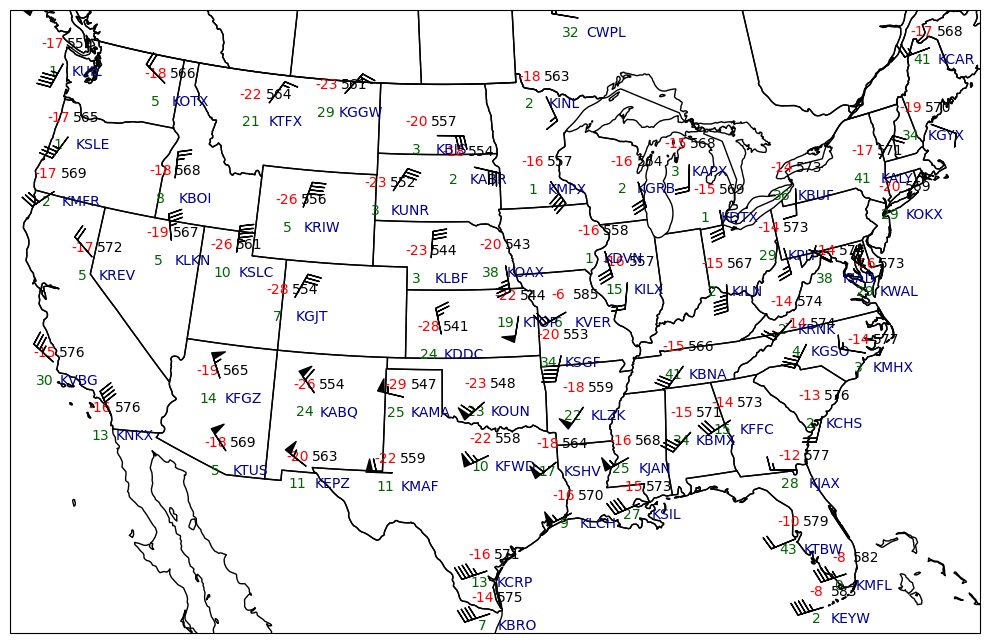

In [20]:
#map projection jusing a Lambert Conformal Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)

#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))


#create stationplots
stationplots = StationPlot(ax,data_500['longitude'],data_500['latitude'],transform=ccrs.PlateCarree(), clip_on=True, fontsize=10)

#temperature in red to  code height
stationplots.plot_parameter((-1,1), data_500['temperature'].values, color='red')

#dewpoint DEPRESSION in dark green
stationplots.plot_parameter((-1,-1), data_500['temperature'].values - data_500['dewpoint'].values,color='darkgreen')

#height (need to format to be the first 3 digits)
stationplots.plot_parameter((1,1), data_500['height'].values, color='black', formatter=lambda v: format(v, '.0f')[:3])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data_500['station'].values,color='darkblue')

#wind in black
stationplots.plot_barb(data_500['u_wind'].values, data_500['v_wind'].values, color='black', zorder=10)

fig.tight_layout()

#save the map as upper_air_500.png
plt.savefig('upper_air_500.png')


### CREATE 500mb HEIGHT CONTOURS (ISOHYPSES) ###

In [8]:
#convert the data to x, y, and z locations on the projected map
x,y,z = proj.transform_points(ccrs.PlateCarree(), data_500['longitude'].values, data_500['latitude'].values).T

#remove nans
mask = ~np.isnan(x)

#interpolate the data to a grid
grdx,grdy,hght = interpolate_to_grid(x[mask], y[mask], data_500['height'].values[mask],interp_type='cressman', search_radius=1000000,
                                     minimum_neighbors=3, hres=100000)



### PLOT UPPER AIR STATION PLOTS & CONTOURS ###

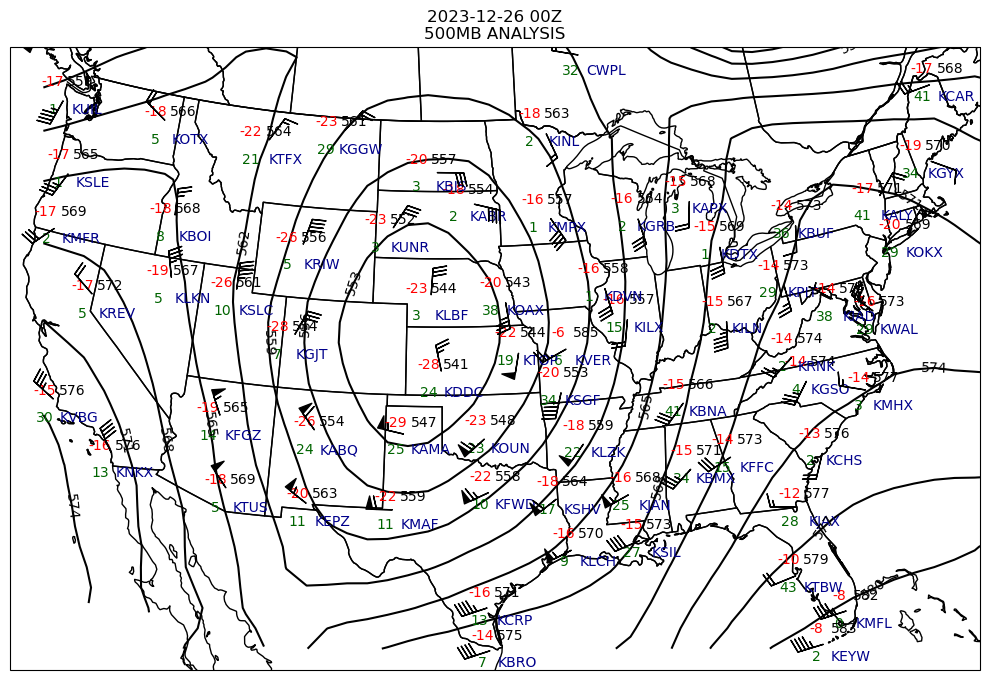

In [19]:
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)

#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))


#create stationplots
stationplots = StationPlot(ax,data_500['longitude'],data_500['latitude'],transform=ccrs.PlateCarree(), clip_on=True, fontsize=10)

#temperature in red to  code height
stationplots.plot_parameter((-1,1), data_500['temperature'].values, color='red')

#dewpoint DEPRESSION in dark green
stationplots.plot_parameter((-1,-1), data_500['temperature'].values - data_500['dewpoint'].values,color='darkgreen')

#height (need to format to be the first 3 digits)
stationplots.plot_parameter((1,1), data_500['height'].values, color='black', formatter=lambda v: format(v, '.0f')[:3])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data_500['station'].values,color='darkblue')

#wind in black
stationplots.plot_barb(data_500['u_wind'].values, data_500['v_wind'].values, color='black', zorder=10)

fig.tight_layout()

#plot contours from 4600m to 6000m with 60m interval
clevs = np.arange(4600,6000,30)
cs = ax.contour(grdx,grdy,hght, clevs, colors='black')
ax.clabel(cs,inline=True, zorder=10, fmt=lambda v: format(v, '.0f')[:3])

#add a title with the date
plt.title(f'{dt.strftime("%Y-%m-%d %HZ")}\n500MB ANALYSIS')

#save the map as contour_500.png
plt.savefig('contour_500.png')